In [368]:
import pandas as pd
import numpy as np

#Text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords

#XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

#Scikit learn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

# Reading data

In [369]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

In [370]:
train_raw.sample(5)

,id,keyword,location,text,target
5134,7323,nuclear%20reactor,Paris (France),Magnetic and electrostatic nuclear fusion reac...,0
5563,7938,rainstorm,"Pennsylvania, USA",RAIN RAIN GO AWAY... A soaker is on the way \n...,0
2416,3475,derailed,"Enterprise, Alabama",Has #IdentityTheft Derailed Your #TaxReturn? \...,0
2162,3102,deaths,Top secret bunker,@MayorofLondon pls reduce cyclist deaths with ...,1
5463,7793,police,Los Angeles,.@slosheriff: 2 South Gate police officers and...,0


In [371]:
test_raw.sample(5)

,id,keyword,location,text
3015,9959,tsunami,IG : Sincerely_TSUNAMI,@AshNiggas tink ...
578,1876,burning,NaN,@sar_giuliani I'm currently burning my skin off??
494,1612,bombed,"Vernal, Utah",Picture of cute sleeping puppy photo bombed by...
2068,6947,massacre,Kenya,#FromTheDesk of King George Kenyatta Muumbo at...
1513,5036,eyewitness,"Cape Town, South Africa",Cape Town: Thousands living on Cape Town's str...


Checking data imbalance

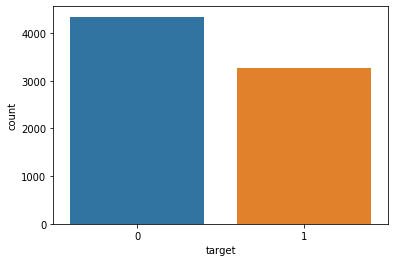

In [372]:
sns.countplot(data = train_raw, x = 'target')
plt.show()

Let's get started with some simple EDA.
We'll make the usual train_copy and test_copy to proceed.

In [373]:
train_copy = train_raw.copy(deep = True)
test_copy = test_raw.copy(deep = True)

# EDA

### Keywords feature

In [374]:
keyword_grouping = train_copy.groupby('keyword')
count_by_keyword = keyword_grouping.count()['target'].to_frame()
#Since target is never NaN, it's total count = number of those keywords appearing

In [375]:
count_by_keyword

,target
keyword,
ablaze,36
accident,35
aftershock,34
airplane%20accident,35
ambulance,38
...,...
wounded,37
wounds,33
wreck,37


#### Not sorted by deafult. Using value_counts() instead

In [376]:
df = train_copy['keyword'].value_counts(ascending = False)

In [377]:
df = df.to_frame()[:20] #First 20

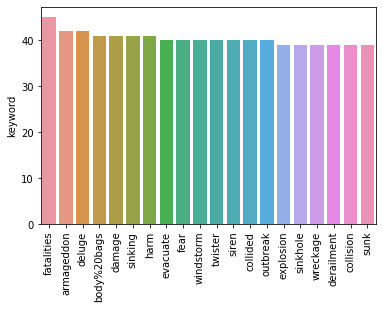

In [378]:
sns.barplot(x = df.index, y = 'keyword', data = df)
plt.xticks(rotation = 'vertical')
plt.show()

In [379]:
print("Keywords having word 'disaster in them")
train_copy.loc[train_copy['keyword'].str.lower()=='disaster']['target'].value_counts()

Keywords having word 'disaster in them


0    20
1    15
Name: target, dtype: int64

In [380]:
print("Texts having word 'disaster in them'")
train_copy.loc[train_copy['text'].str.contains('disaster',case = False)]['target'].value_counts()

Texts having word 'disaster in them'


1    102
0     40
Name: target, dtype: int64

### Location feature

In [381]:
train_copy['location'].value_counts(ascending = False)

USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Walker County, Alabama           1
Rochelle, GA                     1
Alameda, CA                      1
PG County, MD                    1
Bartholomew County, Indiana      1
Name: location, Length: 3341, dtype: int64

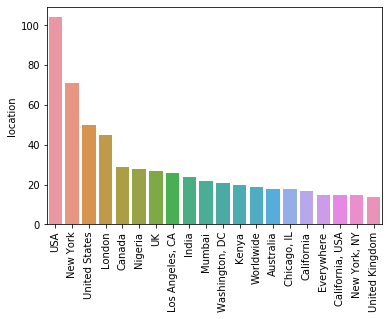

In [382]:
sns.barplot(x = train_copy['location'].value_counts()[:20].index,
            y = train_copy['location'].value_counts()[:20],
            data = train_copy)
plt.xticks(rotation = 'vertical')
plt.show()

We can see a lot of repeating/overlapping areas.<br>
Let us manullay set them

In [383]:
train_copy['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

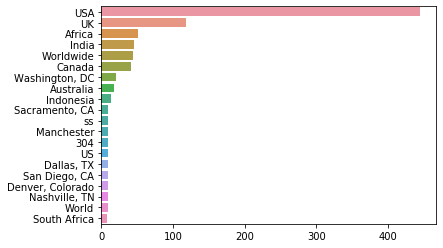

In [384]:
sns.barplot(y = train_copy['location'].value_counts()[:20].index,
           x = train_copy['location'].value_counts()[:20].values,
           data = train_copy)
plt.show()

We still have a lot of overlapping countires/areas. But in summary, we can see USA as being the most affected one.

# Text Data Preprocessing - NLP Starter Section

In [385]:
train_copy['text'].sample(6)

4960        Why must I have a meltdown every few days? ??
1652         @rokiieee_ the game has officially collapsed
2575    @SapphireScallop Destroy oppa image? Oops! The...
7011                        Drunk twister is so hard ????
3382    @batfanuk we enjoyed the show today. Great fun...
3259    Man is equally incapable of seeing the nothing...
Name: text, dtype: object

In [386]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train_copy['text'] = train_copy['text'].apply(lambda x: clean_text(x))
test_copy['text'] = test_copy['text'].apply(lambda x: clean_text(x))

In [387]:
train_copy['text'].sample(5)

2475    consent order on cleanup underway at csx derai...
7252    navy no charges against officer for weapons vi...
1581    i accidentally killed an  day snap streak and ...
3037    usgs eq m    ssw of anza california       eart...
4375              û÷hijacker copsûª back in the dock   
Name: text, dtype: object

### Tokenization

In [388]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train_copy['text'] = train_copy['text'].apply(lambda x : tokenizer.tokenize(x))
test_copy['text'] = test_copy['text'].apply(lambda x : tokenizer.tokenize(x))

In [389]:
train_copy['text'].sample(5)

7058                                [rlyeh, by, upheaval]
5210    [amp, on, the, rare, occasion, i, do, go, out,...
3760    [news, politifiact, harry, reids, percent, of,...
3361    [faan, orders, evacuation, of, abandoned, airc...
7133    [eruption, of, indonesian, volcano, sparks, tr...
Name: text, dtype: object

### Removing stop words

In [390]:
def remove_stopwords(row):
    
    new_list = []
    
    #The row is already tokenized
    for word in row:
        if(word not in stopwords.words('english')):
            new_list.append(word)
    
    return new_list
            

train_copy['text'] = train_copy['text'].apply(lambda x : remove_stopwords(x))
test_copy['text'] = test_copy['text'].apply(lambda x : remove_stopwords(x))

In [391]:
train_copy['text'][1317] #Seeing the above sample example, we can see 'now' was removed.

['playing', 'boat', 'club', 'memories', 'london', 'burning', 'web', 'radio']

### Token Normalization
Stemming and Lemmatization

In [392]:
stemmer = nltk.PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()

#PS, not using these as we'd like to preserve the words as is

In [393]:
def list_to_sent(row):
    string = ' '.join(row)
    return string

train_copy['text'] = train_copy['text'].apply(lambda x : list_to_sent(x))
test_copy['text'] = test_copy['text'].apply(lambda x : list_to_sent(x))

In [394]:
train_copy['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                                       volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

# Tokens into vectors

### Bag of words

In [395]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train_copy['text'])
test_vectors = count_vectorizer.transform(test_copy['text'])

In [396]:
train_vectors[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### TFIDF features for normalization of freq. words

In [397]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))

train_tfidf = tfidf.fit_transform(train_copy['text'])
test_tfidf = tfidf.transform(test_copy["text"])

In [398]:
train_tfidf[0].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

# Models

In [399]:
X_train = train_vectors
y_train = train_copy['target']

X_train_scaled = train_tfidf

X_test = test_vectors
X_test_scaled = test_tfidf

### Logistic Regression Classifier

NON SCALED

In [400]:
log_classifier = LogisticRegression(C = 1.0)
log_scores = model_selection.cross_val_score(log_classifier, 
                                         X_train,
                                         y_train,
                                         cv = 5, 
                                         scoring = 'f1')
print(log_scores)
print(log_scores.sum()/5)

[0.59865255 0.49611063 0.57166948 0.56290774 0.68789809]
0.5834476966398702


SCALED

In [401]:
log_classifier_tfidf = LogisticRegression(C = 1.0)
log_scores_tfidf = model_selection.cross_val_score(log_classifier_tfidf,
                                        X_train_scaled,
                                        y_train,
                                        cv = 5,
                                        scoring = 'f1')
print(log_scores_tfidf)
print(log_scores_tfidf.sum()/5)

[0.57229525 0.49673203 0.54277829 0.46618106 0.64768683]
0.5451346913743611


### Naives Bayes Classifier

NON SCALED

In [402]:
nb_classifier = MultinomialNB()
nb_scores = model_selection.cross_val_score(nb_classifier, 
                                         X_train,
                                         y_train,
                                         cv = 5, 
                                         scoring = 'f1')
print(nb_scores)
print(nb_scores.sum()/5)

[0.63149079 0.60675773 0.68575519 0.64341085 0.72505092]
0.6584930948850116


SCALED

In [403]:
nb_classifier_tfidf = MultinomialNB()
nb_scores_tfidf = model_selection.cross_val_score(nb_classifier_tfidf,
                                        X_train_scaled,
                                        y_train,
                                        cv = 5,
                                        scoring = 'f1')
print(nb_scores_tfidf)
print(nb_scores_tfidf.sum()/5)

[0.57590597 0.57092511 0.61135371 0.5962963  0.7393745 ]
0.6187711183101462


# Submission

In [404]:
def get_best_score(model):
    
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
    return model.best_score_

In [405]:
#Using Naive Bayes

param_grid = {'alpha':[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,
                      1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,
                      5,10,100],
              'fit_prior' : [True, False]
             }

best_nb = GridSearchCV(MultinomialNB(), param_grid, cv = 5, refit = True,
                      verbose = 0)

In [406]:
best_nb.fit(X_train,y_train)

get_best_score(best_nb)

0.7250832827870161
{'alpha': 10, 'fit_prior': True}
MultinomialNB(alpha=10, class_prior=None, fit_prior=True)


0.7250832827870161

In [407]:
nb_preds = best_nb.predict(X_test)
nb_preds

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [408]:
nb_sub = pd.read_csv('sample_submission.csv')

nb_sub.head(3)

,id,target
0,0,0
1,2,0
2,3,0


In [409]:
nb_sub['target'] = nb_preds

In [411]:
nb_sub.head(3)

,id,target
0,0,1
1,2,0
2,3,1


In [412]:
nb_sub.to_csv("NaiveBayes.csv", index = False)

In [ ]:
#Result - Top 63%. Time to improve!